## Imprting Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, precision_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
# For XGBoost
from xgboost import XGBClassifier


## Load Dataset

In [2]:
# Load your dataset
df = pd.read_csv("air_quality_with_dominant_healthrisk.csv")

# Display first few rows
df.head()


,PM2.5,PM10,NO2,SO2,CO,O3,AQI,AQI_Category,Dominant_Pollutant,Health_Risk_Level
0,43.67,134.00,20.28,3.41,0.91,21.82,122.93,Moderate,PM10,Moderate
1,30.58,74.42,15.17,3.27,0.96,23.31,74.42,Satisfactory,PM10,Mild
2,66.35,155.68,42.90,3.26,2.54,29.70,137.33,Moderate,PM10,Moderate
3,48.00,99.13,18.56,2.95,1.14,31.01,99.13,Satisfactory,PM10,Mild
4,23.75,63.34,17.21,2.82,1.08,25.82,63.34,Satisfactory,PM10,Mild


## Data pre-processing

In [3]:
# Check for missing values
print(df.isnull().sum())

# Fill or drop missing values if any
df = df.dropna()

# Display info
df.info()


PM2.5                 0
PM10                  0
NO2                   0
SO2                   0
CO                    0
O3                    0
AQI                   0
AQI_Category          0
Dominant_Pollutant    0
Health_Risk_Level     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 0 to 1754
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PM2.5               1755 non-null   float64
 1   PM10                1755 non-null   float64
 2   NO2                 1755 non-null   float64
 3   SO2                 1755 non-null   float64
 4   CO                  1755 non-null   float64
 5   O3                  1755 non-null   float64
 6   AQI                 1755 non-null   float64
 7   AQI_Category        1755 non-null   object 
 8   Dominant_Pollutant  1755 non-null   object 
 9   Health_Risk_Level   1755 non-null   object 
dtypes: float64(7), object(3)
memory usage: 137.2+ K

## Create Derived Columns
1. Dominant_Pollutant – pollutant with the highest concentration
2. Health_Risk_Level – based on AQI category

In [4]:
# Dominant pollutant (highest among PM2.5, PM10, NO2, SO2, CO, O3)
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
df['Dominant_Pollutant'] = df[pollutants].idxmax(axis=1)

# Health Risk Level based on AQI_Category
risk_map = {
    'Good': 'Low',
    'Satisfactory': 'Mild',
    'Moderate': 'Moderate',
    'Poor': 'High',
    'Very Poor': 'Severe',
    'Severe': 'Extreme'
}
df['Health_Risk_Level'] = df['AQI_Category'].map(risk_map)
df.head()


,PM2.5,PM10,NO2,SO2,CO,O3,AQI,AQI_Category,Dominant_Pollutant,Health_Risk_Level
0,43.67,134.00,20.28,3.41,0.91,21.82,122.93,Moderate,PM10,Moderate
1,30.58,74.42,15.17,3.27,0.96,23.31,74.42,Satisfactory,PM10,Mild
2,66.35,155.68,42.90,3.26,2.54,29.70,137.33,Moderate,PM10,Moderate
3,48.00,99.13,18.56,2.95,1.14,31.01,99.13,Satisfactory,PM10,Mild
4,23.75,63.34,17.21,2.82,1.08,25.82,63.34,Satisfactory,PM10,Mild


## Encode Categorical Columns

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Use separate encoders so we don't overwrite mappings
label_enc_cat = LabelEncoder()        # for AQI_Category
label_enc_risk = LabelEncoder()       # for Health_Risk_Level

df['AQI_Category_Encoded'] = label_enc_cat.fit_transform(df['AQI_Category'])
df['Health_Risk_Level_Encoded'] = label_enc_risk.fit_transform(df['Health_Risk_Level'])

# Check mapping
cat_mapping = dict(zip(label_enc_cat.classes_, label_enc_cat.transform(label_enc_cat.classes_)))
risk_mapping = dict(zip(label_enc_risk.classes_, label_enc_risk.transform(label_enc_risk.classes_)))
print("AQI category mapping:", cat_mapping)
print("Health risk mapping:", risk_mapping)


AQI category mapping: {'Good': np.int64(0), 'Moderate': np.int64(1), 'Poor': np.int64(2), 'Satisfactory': np.int64(3), 'Severe': np.int64(4), 'Very Poor': np.int64(5)}
Health risk mapping: {'Extreme': np.int64(0), 'High': np.int64(1), 'Low': np.int64(2), 'Mild': np.int64(3), 'Moderate': np.int64(4), 'Severe': np.int64(5)}


## Train-Test Split

In [7]:
# Features
X = df[pollutants]

# Regression target: AQI
y_reg = df['AQI']

# Classification target: AQI_Category_Encoded
y_clf = df['AQI_Category_Encoded']

# Split for regression
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Split for classification
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_clf, test_size=0.2, random_state=42)


## Feature Scaling

In [8]:
# Regression scaling
scaler_r = StandardScaler()
X_train_r = scaler_r.fit_transform(X_train_r)
X_test_r = scaler_r.transform(X_test_r)

# Classification scaling
scaler_c = StandardScaler()
X_train_c = scaler_c.fit_transform(X_train_c)
X_test_c = scaler_c.transform(X_test_c)


Regression Models & Evaluation

In [9]:
# Define regression models
regressors = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Dict to store results
reg_results = {}

for name, model in regressors.items():
    model.fit(X_train_r, y_train_r)
    y_pred = model.predict(X_test_r)
    r2 = r2_score(y_test_r, y_pred)
    mae = mean_absolute_error(y_test_r, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_r, y_pred))
    
    reg_results[name] = {
        "model": model,
        "r2": r2,
        "mae": mae,
        "rmse": rmse
    }
    
    print(f"--- {name} Regression ---")
    print(f"R² Score: {r2:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}\n")

# Identify the best regression model based on R²
best_reg_name = max(reg_results, key=lambda x: reg_results[x]['r2'])
best_reg_model = reg_results[best_reg_name]['model']
print(f"Best Regression Model: {best_reg_name} (R² = {reg_results[best_reg_name]['r2']:.3f})")


--- Random Forest Regression ---
R² Score: 0.989, MAE: 0.887, RMSE: 3.580

--- ExtraTrees Regression ---
R² Score: 0.988, MAE: 1.094, RMSE: 3.791

--- GradientBoosting Regression ---
R² Score: 0.982, MAE: 1.948, RMSE: 4.627

Best Regression Model: Random Forest (R² = 0.989)


## Classification Models & Evaluation

In [10]:
# Define classification models
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Dict to store classification results
clf_results = {}

for name, model in classifiers.items():
    model.fit(X_train_c, y_train_c)
    y_pred = model.predict(X_test_c)
    acc = accuracy_score(y_test_c, y_pred)
    f1 = f1_score(y_test_c, y_pred, average='macro')
    prec = precision_score(y_test_c, y_pred, average='macro')
    
    clf_results[name] = {
        "model": model,
        "accuracy": acc,
        "f1": f1,
        "precision": prec
    }
    
    print(f"--- {name} Classification ---")
    print(f"Accuracy: {acc:.3f}, F1 Score: {f1:.3f}, Precision: {prec:.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_c, y_pred))
    print("\n")

# Identify the best classification model based on F1 score
best_clf_name = max(clf_results, key=lambda x: clf_results[x]['f1'])
best_clf_model = clf_results[best_clf_name]['model']
print(f"✅ Best Classification Model: {best_clf_name} (F1 Score = {clf_results[best_clf_name]['f1']:.3f})")


--- Random Forest Classification ---
Accuracy: 0.986, F1 Score: 0.866, Precision: 0.989
Confusion Matrix:
[[ 64   0   0   0]
 [  0 105   0   2]
 [  0   2   1   0]
 [  1   0   0 176]]


--- Logistic Regression Classification ---
Accuracy: 0.954, F1 Score: 0.838, Precision: 0.959
Confusion Matrix:
[[ 60   0   0   4]
 [  0 104   0   3]
 [  0   2   1   0]
 [  7   0   0 170]]




C:\Users\gnane\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:199: UserWarning: [11:44:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost Classification ---
Accuracy: 0.989, F1 Score: 0.597, Precision: 0.595
Confusion Matrix:
[[ 64   0   0   0   0]
 [  0 106   0   1   0]
 [  0   2   0   0   1]
 [  0   0   0 177   0]
 [  0   0   0   0   0]]


✅ Best Classification Model: Random Forest (F1 Score = 0.866)


C:\Users\gnane\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Test with New Input

In [28]:
risk_map = {
    "Good": "Air quality is satisfactory. No health risk.",
    "Satisfactory": "Air quality is acceptable. Minor discomfort for sensitive groups.",
    "Moderate": "Acceptable air quality, but sensitive groups should limit outdoor activities.",
    "Poor": "May cause breathing discomfort to sensitive people.",
    "Very Poor": "Health effects may be experienced. Limit outdoor exposure.",
    "Severe": "Serious health effects. Avoid outdoor activity."
}


def predict_air_quality(pm25, pm10, no2, so2, co, o3):
    # Create dataframe for input
    new_data = pd.DataFrame([{
        "PM2.5": pm25,
        "PM10": pm10,
        "NO2": no2,
        "SO2": so2,
        "CO": co,
        "O3": o3
    }])

    # Scale for regression and classification
    scaled_r = scaler_r.transform(new_data)
    scaled_c = scaler_c.transform(new_data)

    # Predict AQI using regression model
    pred_aqi = best_reg_model.predict(scaled_r)[0]

    # Predict category using classification model
    pred_cat_encoded = best_clf_model.predict(scaled_c)[0]
    pred_cat = label_enc_cat.inverse_transform([pred_cat_encoded])[0]   # ✅ fixed here



    health_risk = risk_map.get(pred_cat, "Unknown")

    print("--------------------------------------------------")
    print(f"Predicted AQI: {pred_aqi:.2f}")
    print(f"Predicted Category: {pred_cat}")
    print(f"Health Risk Level: {health_risk}")


C:\Users\gnane\AppData\Local\Temp\ipykernel_36924\686626965.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_importance.index, palette='viridis')


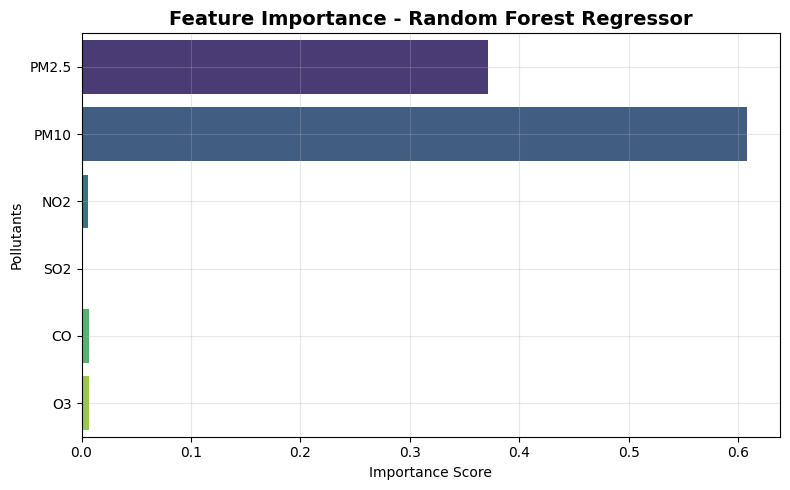

In [29]:
feature_importance = pd.Series(best_reg_model.feature_importances_, index=pollutants)
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance, y=feature_importance.index, palette='viridis')
plt.title("Feature Importance - Random Forest Regressor", fontsize=14, fontweight='bold')
plt.xlabel("Importance Score")
plt.ylabel("Pollutants")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

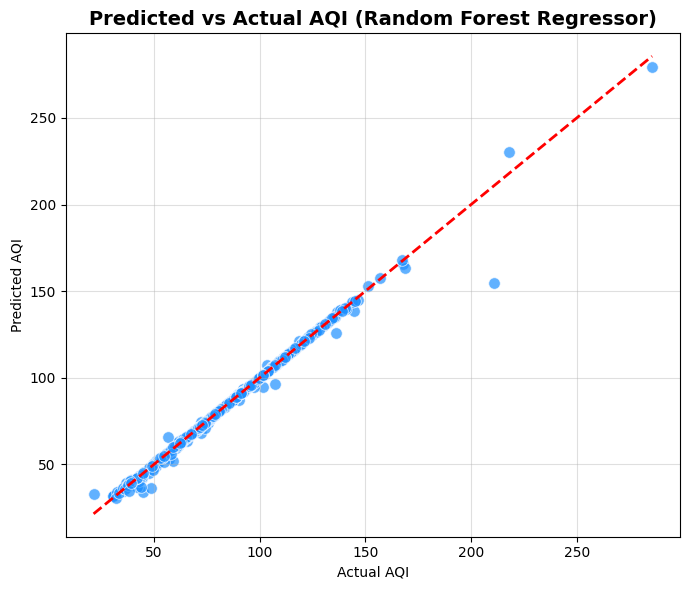

In [30]:
y_pred_rf = best_reg_model.predict(X_test_r)

plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test_r, y=y_pred_rf, color="dodgerblue", alpha=0.7, s=70)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
plt.title("Predicted vs Actual AQI (Random Forest Regressor)", fontsize=14, fontweight='bold')
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

C:\Users\gnane\AppData\Local\Temp\ipykernel_36924\3634189259.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=regression_scores, x='Model', y='R² Score', palette='coolwarm')


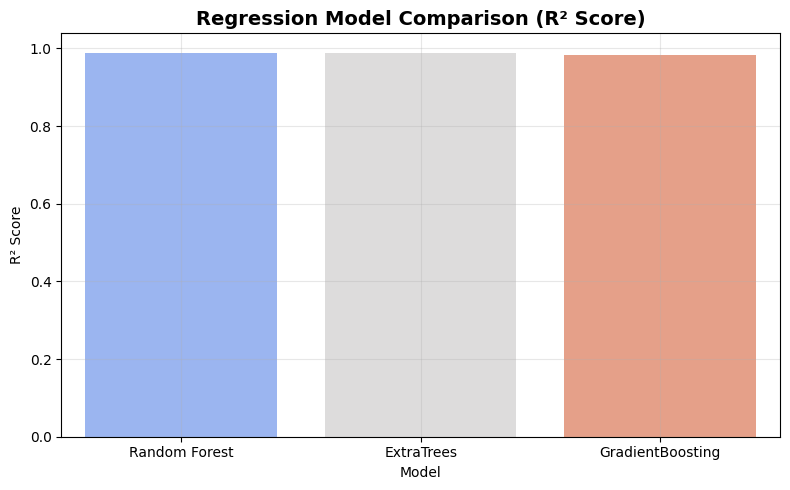

In [31]:
regression_scores = pd.DataFrame({
    'Model': list(reg_results.keys()),
    'R² Score': [reg_results[m]['r2'] for m in reg_results],
    'MAE': [reg_results[m]['mae'] for m in reg_results],
    'RMSE': [reg_results[m]['rmse'] for m in reg_results]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=regression_scores, x='Model', y='R² Score', palette='coolwarm')
plt.title("Regression Model Comparison (R² Score)", fontsize=14, fontweight='bold')
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\gnane\AppData\Local\Temp\ipykernel_36924\3463388405.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=classification_scores, x='Model', y='Accuracy', palette='crest')


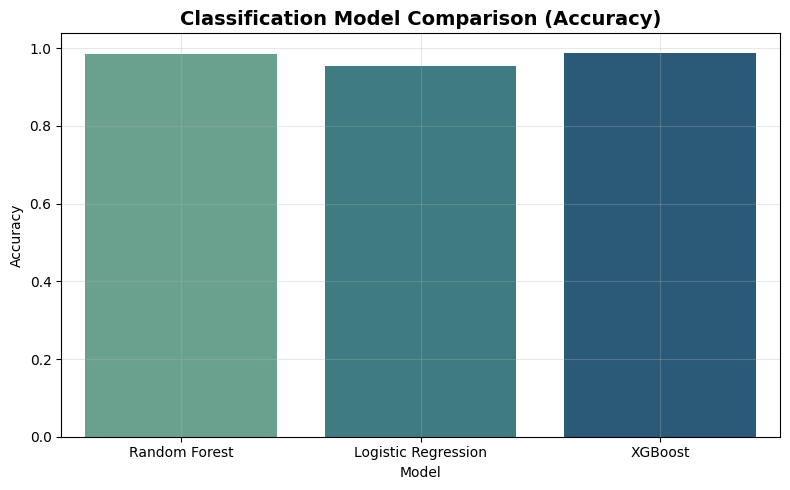

In [32]:
classification_scores = pd.DataFrame({
    'Model': list(clf_results.keys()),
    'Accuracy': [clf_results[m]['accuracy'] for m in clf_results],
    'F1 Score': [clf_results[m]['f1'] for m in clf_results],
    'Precision': [clf_results[m]['precision'] for m in clf_results]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=classification_scores, x='Model', y='Accuracy', palette='crest')
plt.title("Classification Model Comparison (Accuracy)", fontsize=14, fontweight='bold')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [34]:
test_cases = pd.DataFrame([
    {"PM2.5": 30, "PM10": 70, "NO2": 15, "SO2": 3, "CO": 0.8, "O3": 20},
    {"PM2.5": 60, "PM10": 150, "NO2": 30, "SO2": 5, "CO": 1.2, "O3": 25},
    {"PM2.5": 120, "PM10": 250, "NO2": 45, "SO2": 9, "CO": 2.0, "O3": 40},
    {"PM2.5": 200, "PM10": 400, "NO2": 80, "SO2": 15, "CO": 4.5, "O3": 60}
])

print("\n📊 TEST CASE PREDICTIONS\n")
for i, row in test_cases.iterrows():
    predict_air_quality(row['PM2.5'], row['PM10'], row['NO2'], row['SO2'], row['CO'], row['O3'])



📊 TEST CASE PREDICTIONS

--------------------------------------------------
Predicted AQI: 70.03
Predicted Category: Satisfactory
Health Risk Level: Air quality is acceptable. Minor discomfort for sensitive groups.
--------------------------------------------------
Predicted AQI: 133.91
Predicted Category: Moderate
Health Risk Level: Acceptable air quality, but sensitive groups should limit outdoor activities.
--------------------------------------------------
Predicted AQI: 306.01
Predicted Category: Poor
Health Risk Level: May cause breathing discomfort to sensitive people.
--------------------------------------------------
Predicted AQI: 335.26
Predicted Category: Poor
Health Risk Level: May cause breathing discomfort to sensitive people.


In [36]:
import joblib

# Save models
joblib.dump(best_reg_model, "best_regression_model.pkl")
joblib.dump(best_clf_model, "best_classification_model.pkl")

# Save scalers
joblib.dump(scaler_r, "scaler_regression.pkl")
joblib.dump(scaler_c, "scaler_classification.pkl")

# Save label encoder
joblib.dump(label_enc_cat, "label_encoder.pkl")


['label_encoder.pkl']